In [1]:
# # !!! only uncomment and run when using colab !!!
import os
os.chdir("/content")
! pwd
isExist = os.path.exists("UQpresentation")
if not isExist:
  os.mkdir("UQpresentation")
os.chdir("UQpresentation") 
!pwd
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
!ls
os.chdir("/content/UQpresentation/CPlantBox/")
! git checkout UQpresentation # switch to the branch with the presentation
! git pull #get latest version 
! cmake . #build
! make
os.chdir("/content/UQpresentation/CPlantBox/tutorial/jupyter/UQ_15_08_2022/") #go to correct directory

# Coupled carbon and water flow in CPlantBox

## Simulation of water and carbon movement 


In the following we will show how to compute the couple water and carbo flow in the plant. 



We consider dynamic plant and a static soil. 
To compute the carbon flux, we use the code developped by Lacointe et al. (2019).

**Reference**

A Lacointe and P. Minchin. A mechanistic model to predict distribution of carbon among multiple sinks. *Methods in molecular biology* (Clifton, N.J.) vol. 2014, 2019.
	

In [39]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
#import vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt
from phloem_flux import PhloemFluxPython  
from parametersSucroseFlow import *


## 1. Define initial conditions

In [42]:

weatherInit = weather(0)
simDuration = 7 # [day] init simtime
simMax = 8
dt =1/24
depth = 60
verbose = False


# plant system 
pl = pb.MappedPlant(seednum = 2) 
path = "../../../modelparameter/plant/"
name = "Triticum_aestivum_adapted_2021"
pl.readParameters(path + name + ".xml")

sdf = pb.SDF_PlantBox(np.Inf, np.Inf, depth )
pl.setGeometry(sdf) # creates soil space to stop roots from growing out of the soil


pl.initialize(verbose )
pl.simulate(simDuration, False)


#for post-processing
Q_in  = 0
Q_out = 0
AnSum = 0
filename = "phloemoutputs.txt" 

Q_Rmbu      = np.array([0.])
Q_Grbu      = np.array([0.])
Q_Exudbu    = np.array([0.])
Q_STbu    = np.array([0.])

Q_Rmall      = np.array([])
Q_Grall      = np.array([])
Q_Exudall    = np.array([])
Growthall    = np.array([])
time = np.array([])
Ntbu = 1

## 2. Define static soil

In [43]:

min_b = [-3./2, -12./2, -61.]#distance between wheat plants
max_b = [3./2, 12./2, 0.]
cell_number = [6, 24, 61] #soil resolution
layers = depth; soilvolume = (depth / layers) * 3 * 12
k_soil = [] #conductivity of soil when in contact with roots
p_mean = weatherInit['p_mean'] #mean soil water potential
p_bot = p_mean + depth/2
p_top = p_mean - depth/2
sx = np.linspace(p_top, p_bot, depth) #soil water potential per voxel

picker = lambda x,y,z : max(int(np.floor(-z)),-1) 
pl.setSoilGrid(picker)  # maps segment


## 3. create object to compute carbon and water flux

In [44]:
#give initial guess of leaf water potential and internal CO2 partial pressure (to start computation loop)
r = PhloemFluxPython(pl,psiXylInit = min(sx),ciInit = weatherInit["cs"]*0.5)


## 4. set other parameters and initial variable

In [45]:
#for photosynthesis
r.g0 = 8e-3              #residual stomatal opening at night 
r.VcmaxrefChl1 =1.28     #influence of leaf chlorophyl content on carboxylation rate
r.VcmaxrefChl2 = 8.33    #influence of leaf chlorophyl content on carboxylation rate
r.a1 = 0.5               #ci/(cs - ci)
r.a3 = 1.5               # VcrefMax to VjrefMax ratio
r.alpha = 0.4            #effect of light on photon flux rate
r.theta = 0.6            #effect of light on photon flux rate
r.cs = weatherInit["cs"] #external CO2 partial rpessure
SPAD= 41.0
chl_ = (0.114 *(SPAD**2)+ 7.39 *SPAD+ 10.6)/10
r.Chl = np.array( [chl_]) #leaf chlorophyle content (mean value or defined per leaf segment)

#for phloem flow
r = setKrKx_phloem(r)
r.setKrm2([[2e-5]]) #effect of C_ST content on Rm 
r.setKrm1([[10e-2]]) #effect of structural sucrose content on Rm
r.setRhoSucrose([[0.51],[0.65],[0.56]])  #sucrose density per organ type (mmol/cm3)
r.setRmax_st([[14.4,9.0,6.0,14.4],[5.,5.],[15.]]) #maximum growth rate when water and carbon limitation is activated
r.KMfu = 0.11                                     #michaelis menten coefficient for usage of sucrose
r.beta_loading = 0.6 #feedback effect of sieve tube concentraiton on loading from mesophyll
r.Vmaxloading = 0.05 #mmol/d, max loading rate from mesophyll
r.Mloading = 0.2                                      #michaelis menten coefficient for loading of sucrose
r.Gr_Y = 0.8 # efficiency of sucrose usage for growth. if <1, we have growth respiration
r.CSTimin = 0.4 #minimum sucrose concentration below which no sucrose usage occures
r.Csoil = 1e-4 #mean soil concentration in sucrose


r.update_viscosity = True #update sucrose viscosity according to concentraiton ?
r.atol = 1e-12 #max absolute error for sucrose flow solver
r.rtol = 1e-8 #max relative error for sucrose flow solver


## 5. launch simulation

In [46]:

while simDuration <= simMax: 
    
    Nt = len(r.plant.nodes) 
    weatherX = weather(simDuration) #update seather variables
    r.Qlight = weatherX["Qlight"] #
    r = setKrKx_xylem(weatherX["TairC"], weatherX["RH"], r) #update xylem conductivity data
    
    #compute plant water flow
    r.solve_photosynthesis(sim_time_ = simDuration, sxx_=sx, cells_ = True,RH_ = weatherX["RH"],
        verbose_ = False, doLog_ = False,TairC_= weatherX["TairC"] )
    
    
    AnSum += np.sum(r.Ag4Phloem)*dt #total cumulative carbon assimilaiton
    errLeuning = sum(r.outputFlux) #should be 0 : no storage of water in the plant
    fluxes = np.array(r.outputFlux)
    fluxesSoil = r.soilFluxes(simDuration, r.psiXyl, sx, approx=False) #root water flux per soil voxel
    
    
    #simulation of phloem flow
    startphloem= simDuration
    endphloem = startphloem + dt
    stepphloem = 1
    r.startPM(startphloem, endphloem, stepphloem, ( weatherX["TairC"]  +273.15) , True, filename)
        
    #get ouput of sucroes flow computation    
    Q_ST    = np.array(r.Q_out[0:Nt])          #sieve tube sucrose content
    Q_meso  = np.array(r.Q_out[Nt:(Nt*2)])     #mesophyll sucrose content
    Q_Rm    = np.array(r.Q_out[(Nt*2):(Nt*3)]) #sucrose used for maintenance respiration
    Q_Exud  = np.array(r.Q_out[(Nt*3):(Nt*4)]) #sucrose used for exudation
    Q_Gr    = np.array(r.Q_out[(Nt*4):(Nt*5)]) #sucrose used for growth and growth respiration
    
    C_ST    = np.array(r.C_ST)           #sieve tube sucrose concentraiton
    #Fl      = np.array(r.Fl)             #loading rate from mesophyll to sieve tube
    volST   = np.array(r.vol_ST)         #sieve tube volume
    volMeso   = np.array(r.vol_Meso)      #mesophyll volume     
    C_meso  = Q_meso/volMeso              #sucrose concentration in mesophyll
    Q_in   += sum(np.array(r.AgPhl)*dt)  #total sucrose input in the pant
    Q_out   = Q_Rm + Q_Exud + Q_Gr       #total sucrose lost/used by the plant
    error   = sum(Q_ST + Q_meso + Q_out )- Q_in  #balance residual (error)
    
    delta_ls_i = np.array(r.delta_ls_org_i) #organ length increase at last time step
    delta_ls = np.array(r.delta_ls_org) #total organ length increase
    
    #contatn variantion at the last time step
    Q_ST_i        = Q_ST      - Q_STbu 
    Q_Rm_i        = Q_Rm      - Q_Rmbu
    Q_Gr_i        = Q_Gr      - Q_Grbu
    Q_Exud_i      = Q_Exud    - Q_Exudbu
    Q_out_i       = Q_Rm_i    + Q_Exud_i      + Q_Gr_i
    
    #print some outputs
    print("\n\n\n\t\tat ", int(np.floor(simDuration)),"d", int((simDuration%1)*24),"h",  round(r.Qlight *1e6),"mumol m-2 s-1")
    print("Error in Suc_balance:\n\tabs (mmol) {:5.2e}\trel (-) {:5.2e}".format(error, div0f(error,Q_in, 1.)))
    print("Error in photos:\n\tabs (cm3/day) {:5.2e}".format(errLeuning))
    print("water fluxes (cm3/day):\n\ttrans {:5.2e}\tminExud {:5.2e}\tmaxExud {:5.2e}".format(sum(fluxesSoil.values()), min(fluxesSoil.values()), max(fluxesSoil.values())))
    print("assimilated Sucrose (cm)\tAn {:5.2e}".format(AnSum)) 
    print("sucrose concentration in sieve tube (mmol ml-1):\n\tmean {:.2e}\tmin  {:5.2e} at {:d} segs \tmax  {:5.2e}".format(np.mean(C_ST), min(C_ST), len(np.where(C_ST == min(C_ST) )[0]), max(C_ST)))        
    print('cumulatede \tRm   {:.2e}\tGr   {:.2e}\tExud {:5.2e}'.format(sum(Q_Rm), sum(Q_Gr), sum(Q_Exud)))
    print("aggregated sink repartition at last time step (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm_i)/sum(Q_out_i)*100, 
         sum(Q_Gr_i)/sum(Q_out_i)*100,sum(Q_Exud_i)/sum(Q_out_i)*100))
    print("total aggregated sink repartition (%) :\n\tRm   {:5.1f}\tGr   {:5.1f}\tExud {:5.1f}".format(sum(Q_Rm)/sum(Q_out)*100, 
         sum(Q_Gr)/sum(Q_out)*100,sum(Q_Exud)/sum(Q_out)*100))
    print("growth (cm)\ttot {:5.2e}\ti {:5.2e}".format(sum(delta_ls), sum(delta_ls_i)))      
    
    #plant growth based on Gr
    r.plant.simulate(dt, False)
    simDuration += dt
    
    #for post processing
    Ntbu = Nt
    Nt = len(r.plant.nodes)
    Q_STbu       =   np.concatenate((Q_ST, np.full(Nt - Ntbu, 0.)))
    Q_Rmbu       =   np.concatenate((Q_Rm, np.full(Nt - Ntbu, 0.)))
    Q_Grbu       =   np.concatenate((Q_Gr, np.full(Nt - Ntbu, 0.))) 
    Q_Exudbu     =   np.concatenate((Q_Exud, np.full(Nt - Ntbu, 0.))) 
    
    
    Q_Rmall    = np.append( Q_Rmall  ,sum(Q_Rm_i))
    Q_Grall    = np.append( Q_Grall  ,sum(Q_Gr_i))
    Q_Exudall  = np.append( Q_Exudall,sum(Q_Exud_i))
    Growthall  = np.append( Growthall,sum(delta_ls_i))
    time       = np.append( time ,simDuration)
    





		at  7 d 0 h 480 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) 3.69e-15	rel (-) 2.61e-13
Error in photos:
	abs (cm3/day) -1.92e-10
water fluxes (cm3/day):
	trans -1.56e-02	minExud -5.17e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 1.41e-02
sucrose concentration in sieve tube (mmol ml-1):
	mean 5.17e-01	min  4.97e-01 at 1 segs 	max  5.91e-01
cumulatede 	Rm   2.68e-03	Gr   7.46e-03	Exud 1.59e-04
aggregated sink repartition at last time step (%) :
	Rm    26.0	Gr    72.4	Exud   1.5
total aggregated sink repartition (%) :
	Rm    26.0	Gr    72.4	Exud   1.5
growth (cm)	tot 1.44e+00	i 1.44e+00



		at  7 d 1 h 604 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) 5.23e-15	rel (-) 1.83e-13
Error in photos:
	abs (cm3/day) 5.30e-11
water fluxes (cm3/day):
	trans -1.90e-02	minExud -6.28e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 2.87e-02
sucrose concentration in sieve tube (mmol ml-1):
	mean 5.14e-01	min  4.94e-01 at 1 segs 	max  5.89e-01
cumulatede 	Rm   6.25e-03	Gr   1.80e-02	Exud 




		at  7 d 14 h 240 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) 7.23e-14	rel (-) 3.11e-13
Error in photos:
	abs (cm3/day) -6.44e-11
water fluxes (cm3/day):
	trans -8.77e-03	minExud -2.42e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 2.33e-01
sucrose concentration in sieve tube (mmol ml-1):
	mean 4.58e-01	min  4.41e-01 at 1 segs 	max  5.26e-01
cumulatede 	Rm   5.79e-02	Gr   1.66e-01	Exud 5.50e-03
aggregated sink repartition at last time step (%) :
	Rm    25.6	Gr    72.5	Exud   1.9
total aggregated sink repartition (%) :
	Rm    25.2	Gr    72.4	Exud   2.4
growth (cm)	tot 3.99e+01	i 2.65e+00



		at  7 d 15 h 141 mumol m-2 s-1
Error in Suc_balance:
	abs (mmol) 7.00e-14	rel (-) 2.91e-13
Error in photos:
	abs (cm3/day) -4.86e-11
water fluxes (cm3/day):
	trans -5.51e-03	minExud -1.16e-03	maxExud 0.00e+00
assimilated Sucrose (cm)	An 2.41e-01
sucrose concentration in sieve tube (mmol ml-1):
	mean 4.36e-01	min  4.24e-01 at 1 segs 	max  4.85e-01
cumulatede 	Rm   6.06e-02	Gr   1.72e-01	Ex

## 8. plot some results

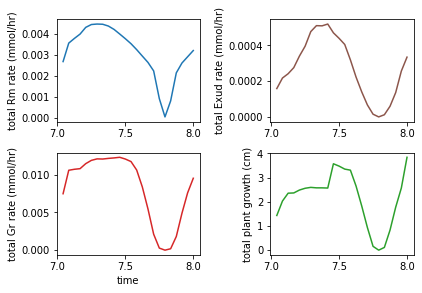

In [47]:


fig, axs = plt.subplots(2,2)
axs[0,0].plot(time, Q_Rmall)
axs[0,0].set(xlabel='', ylabel='total Rm rate (mmol/hr)')
axs[1,0].plot(time, Q_Grall, 'tab:red')
axs[1,0].set(xlabel='time', ylabel='total Gr rate (mmol/hr)')
axs[0,1].plot(time, Q_Exudall , 'tab:brown')
axs[0,1].set(xlabel='', ylabel='total Exud rate (mmol/hr)')
axs[1,1].plot(time, Growthall , 'tab:green')
axs[1,1].set(xlabel='', ylabel='total plant growth (cm)')
fig.tight_layout()
plt.show()

## Take away messages

* Basic idea how to use the class *PhloemFlow*
* The plant growth follows the rate of carbon usage for growth